In [1]:
from general import *

In [2]:
class PositionNeuron:
    NeuronState = namedtuple('NeuronState', ['V', 'w', 'spk', 'I'])

    def __init__(self, parameters):
        super(PositionNeuron, self).__init__()
        self.E_L = parameters['E_L']
        self.V_T = parameters['V_T']
        self.tau = parameters['tau']
        self.tau_W = parameters['tau_W']
        self.tau_epsp = parameters['tau_epsp']
        self.b = parameters['b']
        self.V_R = parameters['V_R']
        self.n = parameters['n']
        self.N_input = parameters['N_input']
        self.dt = parameters['dt']
        self.state = None

    def initialize_state(self):
        self.state = None

    def forward(self, input):
        if self.state is None:
            self.state = self.NeuronState(V=np.full((self.n,), self.E_L),
                                          w=np.zeros((self.n, self.N_input)),
                                          spk=np.zeros(self.n),
                                          I=np.zeros((self.n, self.N_input)))
        V = self.state.V
        w = self.state.w
        I = self.state.I

        w += input * self.b
        V += self.dt * (np.sum(I, axis=1) - V + self.V_R) / self.tau
        I += self.dt * (w - I) / self.tau_epsp
        w += -self.dt * w / self.tau_W

        spk = np.heaviside(V - self.V_T, 0)
        V = (1 - spk) * V + spk * self.V_R

        self.state = self.NeuronState(V=V, w=w, spk=spk, I=I)

        return V, spk

In [3]:
with open('data/spike_sensory', 'rb') as file:
    spike_sensory = pickle.load(file) 
    
with open('data/joint_angles_nostep', 'rb') as file:
    joint_angles_nostep = pickle.load(file) 

time = np.linspace(0, constants['T_TOTAL'], num=constants['N_STEPS'])

position_parameters_uni = {'E_L': -70e-3, 'V_T': -50e-3, 'tau': 25e-3, 'tau_W': 3e-3, 'tau_epsp': 6e-3, 'b': 8e-3,
                           'V_R': -70e-3, 'n': constants['N_ANGLES'], 'N_input': parameters['N_HAIRS'], 'dt': constants['dt']}

position_parameters_bi = {'E_L': -70e-3, 'V_T': -50e-3, 'tau': 25e-3, 'tau_W': 3e-3, 'tau_epsp': 6e-3, 'b': 16e-3,
                          'V_R': -70e-3, 'n': 2 * constants['N_ANGLES'], 'N_input': parameters['N_HAIRS'] // 2, 'dt': constants['dt']}

position_neuron_uni = PositionNeuron(position_parameters_uni)
position_neuron_uni.initialize_state()
position_neuron_bi = PositionNeuron(position_parameters_bi)
position_neuron_bi.initialize_state()

spike_position_uni = np.empty((constants['N_STEPS'], position_parameters_uni['n'], parameters['N_SIMULATIONS']))
spike_position_bi = np.empty((constants['N_STEPS'], position_parameters_bi['n'], parameters['N_SIMULATIONS']))

In [4]:
for k in range(parameters['N_SIMULATIONS']):        
    for i in range(constants['N_STEPS']):
        reshaped_spikes = np.reshape(spike_sensory[i, :, k], (position_parameters_bi['n'], (parameters['N_HAIRS'])))

        _, spike_position_uni[i, :, k] = position_neuron_uni.forward(reshaped_spikes[:18, :])
        _, spike_position_bi[i, :, k] = position_neuron_bi.forward(reshaped_spikes[:, parameters['N_HAIRS'] // 2:])
        
with open('data/spike_position', 'wb') as file:
        pickle.dump(spike_position_bi, file)

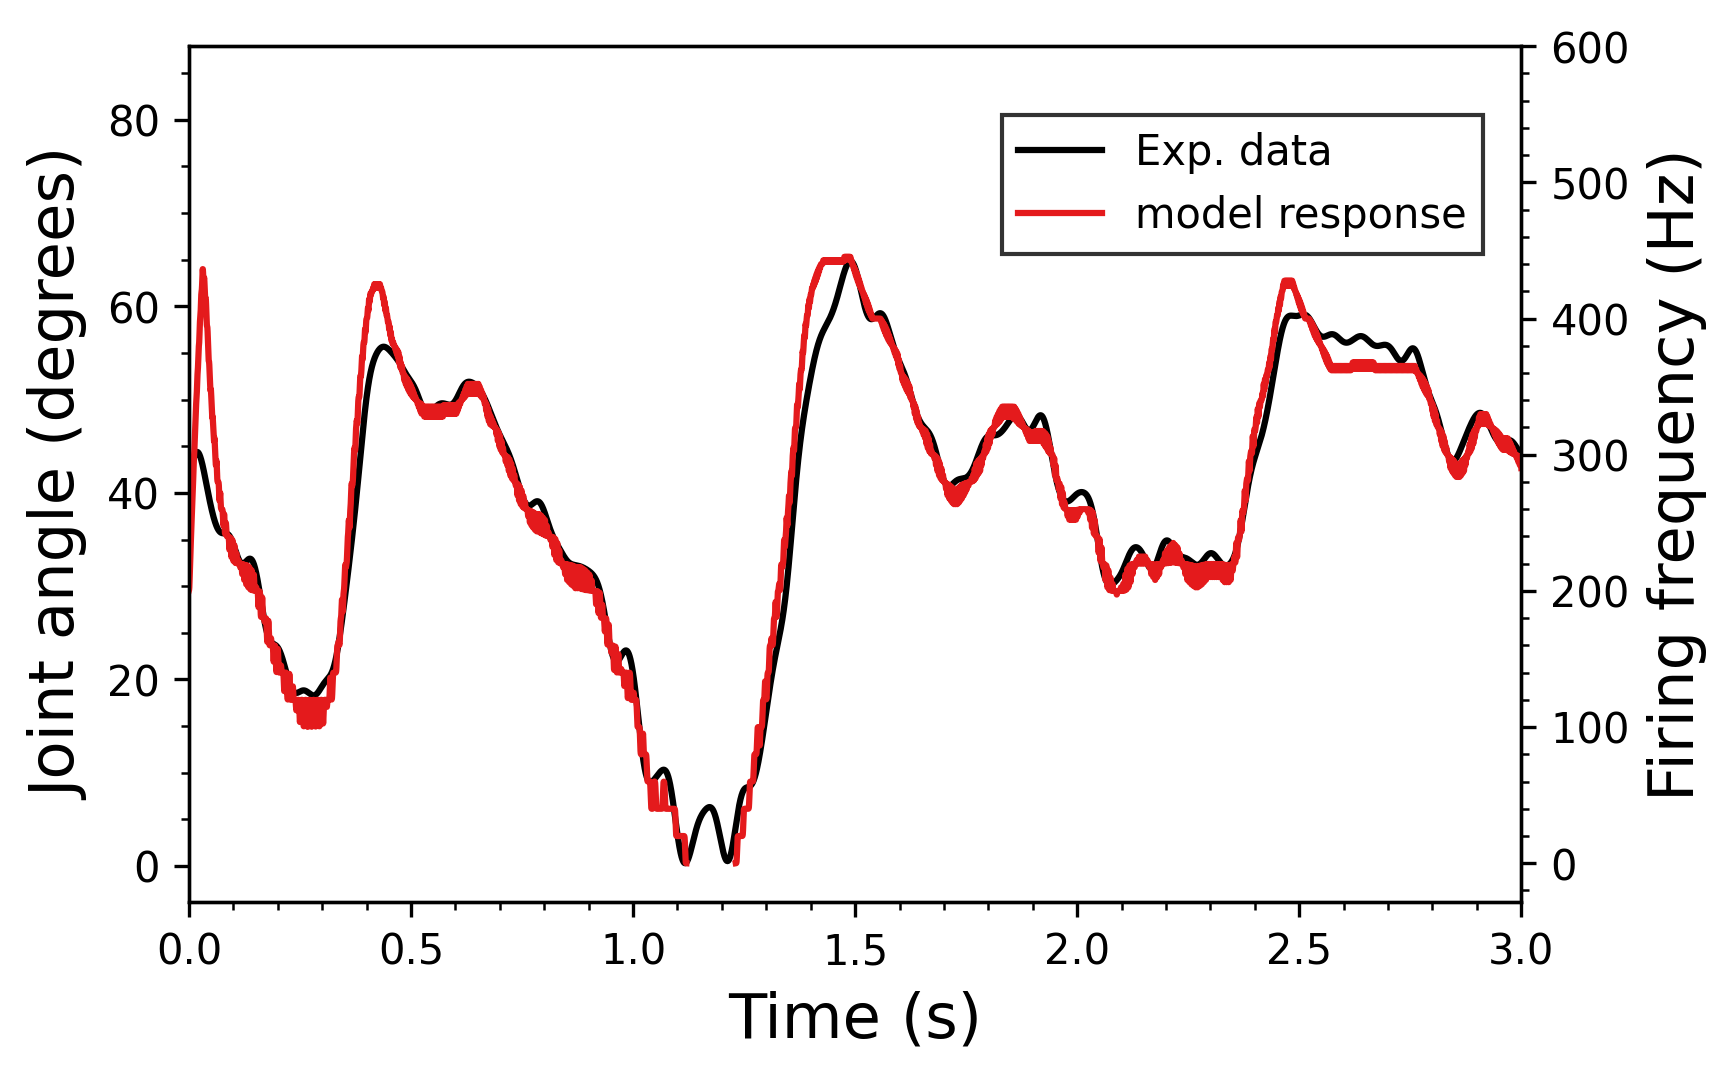

In [5]:
joint_angles = joint_angles_nostep[:, :, 0]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

firing_rate = get_firing_rate_convolve(spike_position_uni[:, 1, 0], constants['dt'], 0.05)

ax2.plot(time, firing_rate, color=custom_colors[0], linestyle=custom_linestyles[0], label='model response')

ax1.plot(time, joint_angles[:, 0], color='black', label='Exp. data')

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Joint angle (degrees)")
ax1.minorticks_on()
ax2.minorticks_on()

ax1.set_xlim([0, 3])
ax2.set_xlim([0, 3])
fig.legend(loc='lower right', fancybox=False, edgecolor='black', bbox_to_anchor=[0.87, 0.75])

ax2.set_ylabel("Firing frequency (Hz)")

fig.tight_layout(pad=0.5)
fig.savefig('Images/position_neurons/uni_position_din_.png')
fig.savefig('Images/position_neurons/uni_position_din_.pdf')

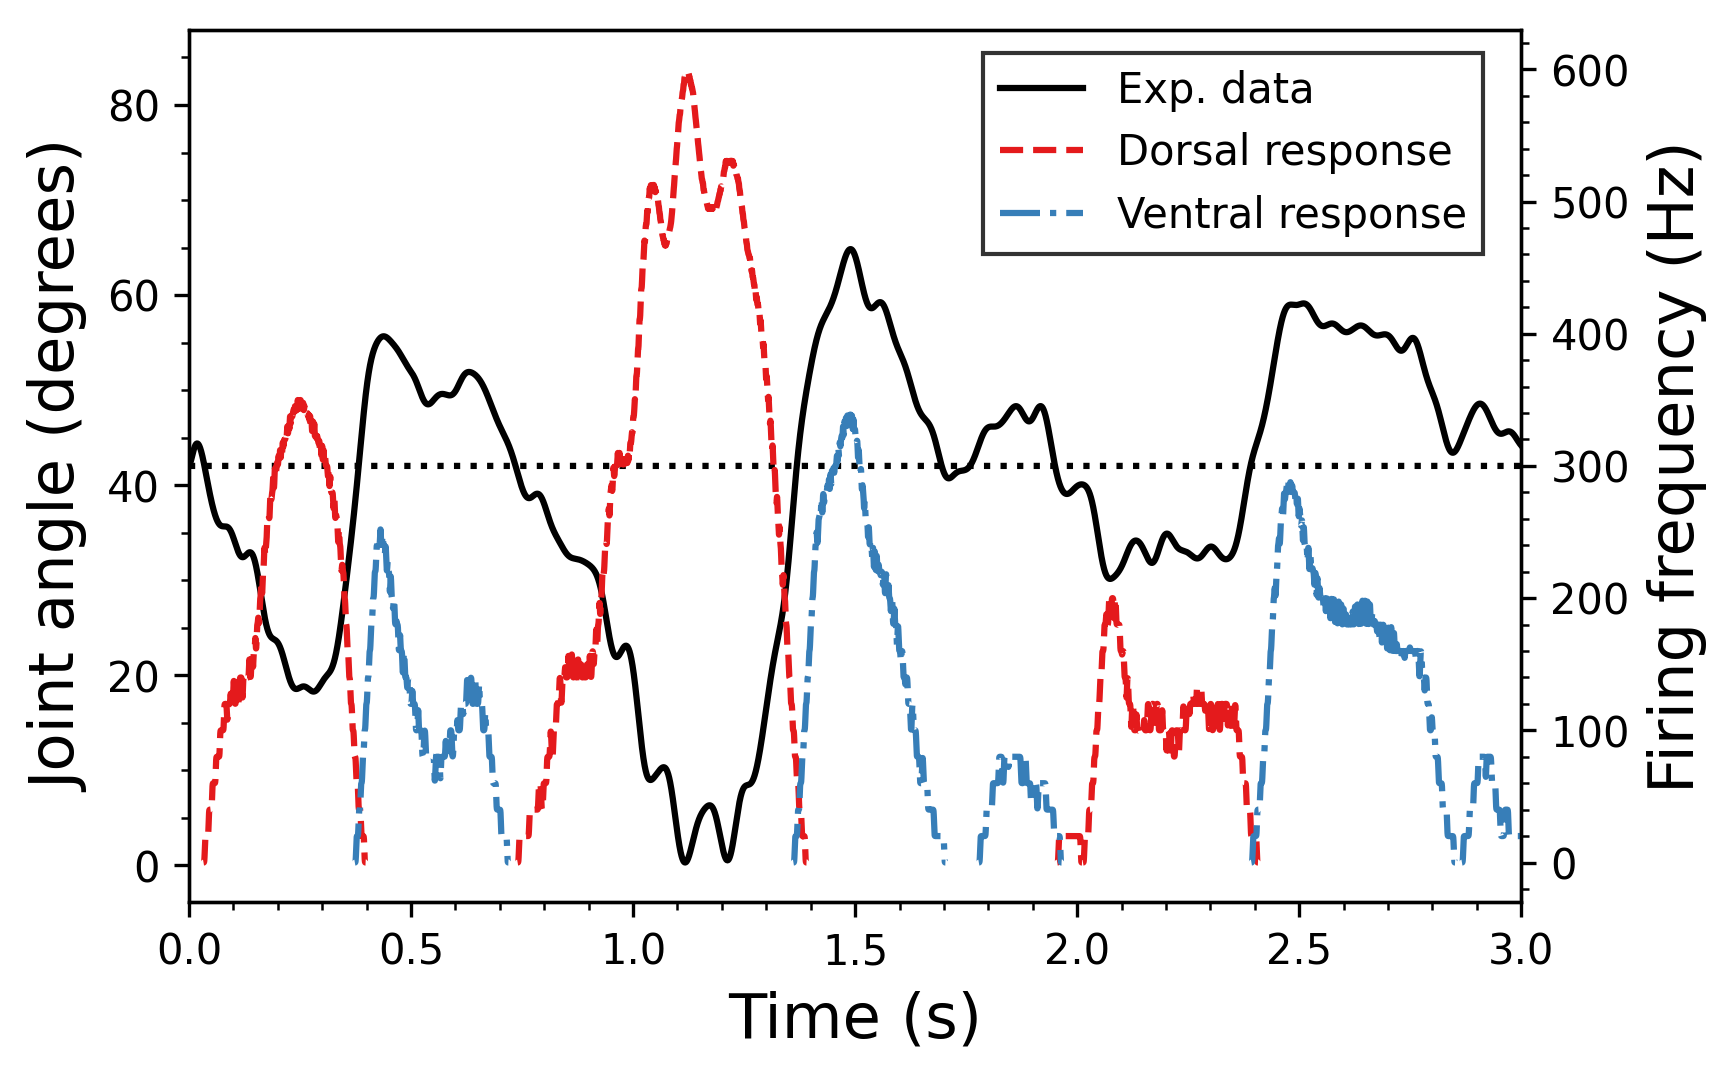

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

handles = ['Dorsal response', 'Ventral response']

for i in range(2):
    firing_rate = get_firing_rate_convolve(spike_position_bi[:, i, 0], constants['dt'], 0.05)
    ax2.plot(time, firing_rate, color=custom_colors[i], linestyle=custom_linestyles[i+1], label = handles[i])


ax1.plot(time, joint_angles[:, 0], color='black', label='Exp. data')
ax1.plot(time, np.full(len(time), np.max(joint_angles[:, 0]) / 2 + np.min(joint_angles[:, 0]) / 2), linestyle='dotted',
         color='black')

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Joint angle (degrees)")
ax1.minorticks_on()
ax2.minorticks_on()

ax1.set_xlim([0, 3])
ax2.set_xlim([0, 3])
fig.legend(loc='lower right', fancybox=False, edgecolor='black', bbox_to_anchor=[0.87, 0.75])

ax2.set_ylabel("Firing frequency (Hz)")

fig.tight_layout(pad=0.5)
fig.savefig('Images/position_neurons/bi_position_din_.png')
fig.savefig('Images/position_neurons/bi_position_din_.pdf')